<a href="https://colab.research.google.com/github/kimjeongsoo20190147/dacon/blob/main/dacon_test_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch-optimizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 6.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tqdm import tqdm
import pandas as pd
from types import SimpleNamespace
from sklearn.preprocessing import LabelEncoder
from transformers import BertModel
#library
import pickle #전처리된 데이터를 파일로 저장하거나 불러올 때 사용
import sys
import re
import cv2

#torch
import torch
import torch.cuda.amp as amp #Pytorch의 혼합 정밀도(Amp, Automatic, Mixed Precision) 기능 제공
from torch.utils.data.dataset import Dataset #데이터를 미니배치 단위로 불러오고, 셔플링 및 병렬 처리 지원
from torch.utils.data import DataLoader
from torch.utils.data.sampler import *

import torch.nn as nn
import torch.nn.functional as F

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau, MultiStepLR, OneCycleLR
'''
CosineAnnealingWarmRestarts: 코사인 함수 기반으로 학습률을 조절하며, 주기마다 학습률을 초기화
CosineAnnealingLR: 코사인 함수 형태로 학습률 감소시킴
ReduceLROnPlateau: 성능 향상이 없을 때 학습률 감소시킴
MultiStepLR: 지정된 에포크마다 학습률 변경
OneCycleLR: 한 사이클 내에서 학습률을 증가시키고 감소시키는 스케줄러
'''
import math
import torch
from torch.optim.optimizer import Optimizer, required #옵티마이저 필수 인자 지정
import torch_optimizer as optim

# utility
from collections import defaultdict #기본 딕셔너리를 생성
import itertools as it #효율적인 반복문 작성을 위해
import random
import matplotlib.pyplot as plt
from timeit import default_timer as timer

from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# transformers
import transformers
from transformers import XLMPreTrainedModel, XLMRobertaModel, XLMRobertaConfig, XLMRobertaTokenizer
from transformers import XLMRobertaForSequenceClassification, BertForSequenceClassification
from transformers import AutoTokenizer
from transformers import BertForSequenceClassification, DistilBertForSequenceClassification, XLNetForSequenceClassification, XLMRobertaForSequenceClassification, XLMForSequenceClassification, RobertaForSequenceClassification
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

전체 데이터 개수: 54609
1.제목, 2.키워드 길이 분석


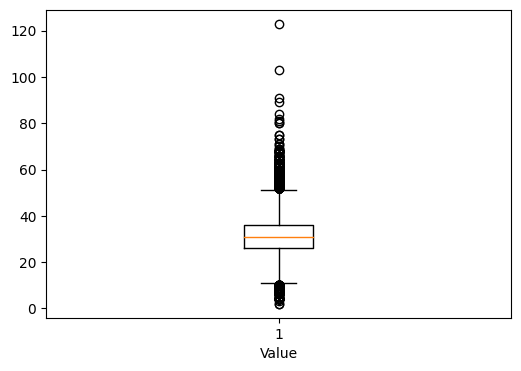

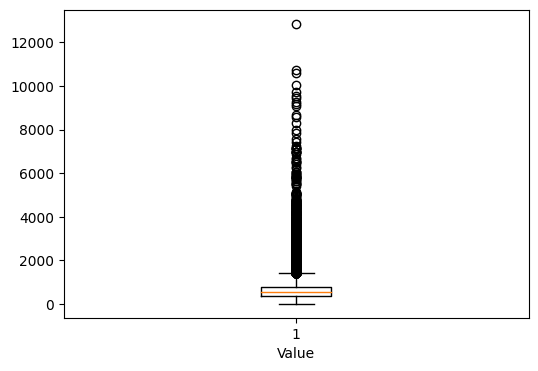

In [4]:
data_title_len = train_df['제목'].apply(len)
data_keyword_len = train_df['키워드'].apply(len)
print("전체 데이터 개수:", len(train_df))

print("1.제목, 2.키워드 길이 분석")
def show_data_length(a,b):
    for x in [a, b]:
        # print(f"------------")
        # print(f"최대값{np.max(x)}")
        # print(f"최소값{np.min(x)}")
        # print(f"평균{np.average(x)}")
        # print(f"표준편차{np.std(x)}")
        # print(f"중간값{np.median(x)}")
        # print(f"제1사분위{np.percentile(x, 25)}")
        # print(f"제3사분위{np.percentile(x, 75)}")

        plt.figure(figsize=(6,4))
        plt.boxplot(x, vert=True)  # vert=False로 수평 박스 플롯 생성
        plt.xlabel('Value')

        # 그래프 보여주기
        plt.show()

show_data_length(data_title_len, data_keyword_len)

In [5]:
#길이 상위 10개 데이터 보여주기
top_10_longest_titles = data_title_len.sort_values( ascending=False).head(10)
top_10_longest_keywords = data_keyword_len.sort_values(ascending=False).head(15)

# 결과 출력
# print(top_10_longest_titles)
# print(top_10_longest_keywords)

# 제목은 80으로 통일
# 키워드는 9000(8679)으로 통일
print("제목은 80, 키워드는 8679로 통일")
train_df = train_df[train_df['제목'].apply(len) <= 80]
print(len(train_df))
train_df = train_df[train_df['키워드'].apply(len) <= 8679]
print(len(train_df))


# train_data_title_len = train_data['제목'].apply(len)
# train_data_keyword_len = train_data['키워드'].apply(len)
# show_data_length(train_data_title_len, train_data_keyword_len)

제목은 80, 키워드는 8679로 통일
54602
54592


In [6]:
class_balance = train_df["분류"].value_counts()
total_samples = class_balance.sum()

class_balance_df = pd.DataFrame(class_balance)
class_balance_df.reset_index(inplace=True)
class_balance_df.columns = ["category", "sample"]
class_balance_df["percentage"] = (class_balance_df["sample"] / total_samples) * 100
class_balance_df["percentage"] = class_balance_df["percentage"].round(2)
class_balance_df["encoded number"] = class_balance_df.index
class_balance_percentage = (class_balance / total_samples) * 100

#Encoded Number
label_encoder = LabelEncoder()
category_encoded_fit = label_encoder.fit_transform(train_df["분류"])
categories = label_encoder.classes_
category_encoded_fit = label_encoder.fit_transform(categories)

for idx in range(len(categories)):
  for i in range(len(categories)):
    if class_balance_df.loc[idx, "category"] == categories[i]:
      class_balance_df.loc[idx, "encoded number"]  = i

print(class_balance_df)

category_weights = list(class_balance_df["percentage"])

         category  sample  percentage  encoded number
0              지역   26944       49.36              55
1          경제:부동산    3454        6.33              10
2        사회:사건_사고    2568        4.70              35
3          경제:반도체    2317        4.24               9
4         사회:사회일반    1480        2.71              36
5        사회:교육_시험     995        1.82              31
6        정치:국회_정당     961        1.76              48
7        사회:의료_건강     950        1.74              38
8        경제:취업_창업     844        1.55              18
9   스포츠:올림픽_아시안게임     841        1.54              45
10       경제:산업_기업     709        1.30              11
11       문화:전시_공연     671        1.23              27
12         경제:자동차     640        1.17              15
13        경제:경제일반     625        1.14               6
14         사회:장애인     621        1.14              39
15         스포츠:골프     617        1.13              41
16          정치:선거     607        1.11              50
17          경제:유통     589   

In [7]:
pip install gensim konlpy scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 42.3 MB/s eta 0:00:00


In [8]:
from sklearn.model_selection import train_test_split

# 데이터 준비
X = train_df.drop(['분류'], axis=1) # decided here what we want to use in our model
Y = train_df["분류"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=8678686)

X_train['combined_text'] = X_train['제목'] + ' ' + X_train['키워드']
X_test['combined_text'] = X_test['제목'] + ' ' + X_test['키워드']

print(X_train['combined_text'])

33192    용인시, 2국 4과 13팀 신설 조직 개편 시의회 통과 용인시,2국,신설,조직,개편...
10639    “친윤 아니면 다 나가란 거냐” 與 조직위원장 인선에 ‘내홍’ 친윤,인선,조직,위원...
52142    용인시 기흥호수공원에 무장애 산책로 조성...도비 13억원 투입 용인시,기흥호수공원...
50529    "유권자 표심 잡아라" 새해 첫 주말 휴일 용인지역 예비후보들 출판기념회 '봇물' ...
24650    로또947회 1등 당첨지역 총 18곳(종합) 당첨지역,로또,당첨,지역,18곳,종합,...
                               ...                        
3541     용인 처인 기흥 15개 지역 성장관리방안 확대 용인,처인,기흥,지역,성장,관리,방안...
9783     용인시, 악취 문제 해결 위해 중앙부처들과 공동 연구 용인시,악취,해결,악취,중앙부...
48326    4일 오후 6시까지 517명 코로나19 확진 어제보다 137명 적어 4일,6시,확진...
52641    용인문화재단, 장애인 문화예술교육지원사업 공모 용인문화재단,공모,장애인,문화,예술,...
37012    “초등학교 50m 옆 AV배우 모인다” 성인 페스티벌 반대 청원 초등학교,50m,A...
Name: combined_text, Length: 43673, dtype: object


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
import konlpy
from gensim.models import Word2Vec
from konlpy.tag import Komoran

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf_both = tfidf_vectorizer.fit_transform(X_train['combined_text'])
X_test_tfidf_both = tfidf_vectorizer.transform(X_test['combined_text'])

komoran = Komoran()

# 2. 데이터를 형태소 단위로 토큰화 (X_train['combined_text'], X_test['combined_text'] 사용)
tokenized_X_train = [komoran.morphs(text) for text in X_train['combined_text']]
tokenized_X_test = [komoran.morphs(text) for text in X_test['combined_text']]

word2vec_model = Word2Vec(sentences=tokenized_X_train, vector_size=230, window=5, min_count=1, workers=4)

def sentence_vector(sentence, model):
    word_vecs = [model.wv[word] for word in sentence if word in model.wv]
    return np.mean(word_vecs, axis=0) if word_vecs else np.zeros(model.vector_size)

X_train_word2vec_both = np.array([sentence_vector(sentence, word2vec_model) for sentence in tokenized_X_train])
X_test_word2vec_both = np.array([sentence_vector(sentence, word2vec_model) for sentence in tokenized_X_test])


label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [20]:
# Train Random Forest model
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import sklearn


rf_model = RandomForestClassifier(n_estimators=100, random_state=2024, max_depth = None, max_features = "sqrt", min_samples_leaf = 1, min_samples_split = 2)

# hypertuned params:
 #{'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt',
 #'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

def randomForest(x_train,y_train,x_test):
      rf_model.fit(x_train, y_train)

      y_pred = rf_model.predict(x_test)
      y_pred_prob = rf_model.predict_proba(x_test)

      return (y_pred, y_pred_prob)

y_pred, y_pred_prob = randomForest(X_train_tfidf_both,y_train_encoded, X_test_tfidf_both)

## Evaluate the model
rf_cm = sklearn.metrics.confusion_matrix(y_test_encoded, y_pred)
rf_model_accuracy = accuracy_score(y_test_encoded,y_pred)
rf_model_precision = precision_score(y_test_encoded,y_pred,average = 'weighted')
rf_model_recall = recall_score(y_test_encoded,y_pred,average = 'weighted')
rf_model_f1 = f1_score(y_test_encoded,y_pred,average = 'weighted')

print(rf_model_accuracy)


# Training set predictions
y_train_pred = rf_model.predict(X_train_word2vec_both)

# Test set predictions (you might have this from your previous code)
y_test_pred = rf_model.predict(X_test_word2vec_both)

# Compute F1 scores for training and test sets
f1_train = f1_score(y_train_encoded, y_train_pred, average='weighted')
f1_test = f1_score(y_test_encoded, y_test_pred, average='weighted')

print(f"F1 Score - Training Set: {f1_train}")
print(f"F1 Score - Test Set: {f1_test}")

0.7621577067497024


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ValueError: X has 230 features, but RandomForestClassifier is expecting 243541 features as input.

In [ ]:
# Cross Validation:

#stratified k-fold-method (good for imbalanced dataset)

X_CV = X_train_word2vec_both.copy()
y_CV = y_train_encoded.copy()

# Define the number of folds
folds = 3

# Initialize variables for storing evaluation results and overall scores
eval_core = []
overall_scores = []

random_forest = RandomForestClassifier()

# Initialize variables to store fold-specific evaluation metrics
fold_eval = []

# Initialize k-fold cross-validation
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

for i, (train_index, test_index) in enumerate(skf.split(X_CV, y_CV)):
    # Select data from train and test based on fold indices
    X_CV_train = X_CV[train_index]
    X_CV_test = X_CV[test_index]
    y_CV_train = y_CV[train_index]
    y_CV_test = y_CV[test_index]
    #X_CV_train, X_CV_test = X_CV.iloc[train_index], X_CV.iloc[test_index]
    #y_CV_train, y_CV_test = y_CV.iloc[train_index], y_CV.iloc[test_index]

    # Train a DC classifier with the given parameter k
    model_RF = RandomForestClassifier()
    model_RF.fit(X_CV_train, y_CV_train)

    # Predict on the test set
    y_CV_pred = model_RF.predict(X_CV_test)

    # Compute the accuracy metric for this fold
    accuracy = accuracy_score(y_CV_test, y_CV_pred)
    fold_eval.append(accuracy)

# overall performanc of mdoel as average of acc of folds
per = np.average(fold_eval)

# Diagnostic
print('Overall scores:', fold_eval)

# Find the best performing k based on the highest accuracy
best_k = np.argmax(fold_eval) + 1  # Add 1 to convert to 1-based index
print("Best fold:", best_k)

print("Performance:", per)


In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

rf_model = RandomForestClassifier(n_estimators=100, random_state=2024, max_depth = None, max_features = "sqrt", min_samples_leaf = 1, min_samples_split = 2)

# hypertuned params:
 #{'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt',
 #'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

rf_model.fit(X_train_tfidf_both, y_train_encoded)

In [ ]:
# 2. 예측 수행
y_test_pred = rf_model.predict(X_test_tfidf_both)

# 3. 결과 저장: ID와 예측된 분류 결과를 DataFrame으로 변환
test_results = pd.DataFrame({
    'ID': X_test["ID"],    # 테스트 데이터의 ID
    '분류': label_encoder.inverse_transform(y_test_pred)     # 예측된 분류 값
})

# 4. 결과를 CSV 파일로 저장
test_results.to_csv('submission.csv', index=False)


# CSV 결과 예시
print(test_results.head())